# Simulate QSO spectra.

The purpose of this notebook is to demonstrate how to simulate QSO spectra using [simqso](https://github.com/moustakas/simqso).  We also compare the results with the default (PCA-based) QSO template-generating code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [2]:
from desisim.templates import SIMQSO, QSO

In [3]:
import multiprocessing
nproc = multiprocessing.cpu_count() // 2

In [4]:
plt.style.use('seaborn-talk')
%matplotlib inline

#### Specify the random seed so the results are reproducible.

In [5]:
seed = 555
rand = np.random.RandomState(seed)

### Generate a handful of spectra with z=[2-4] extending into the mid-IR and display them.

In [6]:
nmodel = 9

In [7]:
simqso = SIMQSO(maxwave=3e4)

In [8]:
%time flux, wave, meta = simqso.make_templates(nmodel, seed=seed, zrange=(2, 4))

CPU times: user 10.3 s, sys: 375 ms, total: 10.7 s
Wall time: 11.2 s


In [9]:
def qaplot_handful(xlim=None, norm=False, logwave=True, loc='upper right'):
    from matplotlib.ticker import FormatStrFormatter
    srt = np.argsort(meta['REDSHIFT'])
    zz = meta['REDSHIFT'][srt].data
    #print(zz, 1215*(1+zz))
    fig, ax1 = plt.subplots(figsize=(14, 9))
    for ii in range(nmodel):
        if norm:
            ax1.plot(wave, flux[srt[ii], :] / 
                     np.interp(6300, wave, flux[srt[ii], :]) + ii*2,
                     label='z={:.2f}'.format(zz[ii]))
        else:
            ax1.plot(wave, flux[srt[ii], :],
                     label='z={:.2f}'.format(zz[ii]))
    if xlim:
        ax1.set_xlim(xlim)
    if logwave:
        ax1.set_xscale('log')

    ax1.set_ylim(5e-2, ax1.get_ylim()[1])
    #ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax1.set_xlabel('Observed-Frame Wavelength ($\AA$)')
    ax1.legend(loc=loc, ncol=3)
    if norm:
        ax1.set_ylabel('Relative Flux (offset for clarity)')        
    else:
        ax1.set_yscale('log')
        ax1.set_ylabel(r'Flux ($10^{-17}\ erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$)')
    ax1.margins(0.02)

#### Plot the full wavelength range.

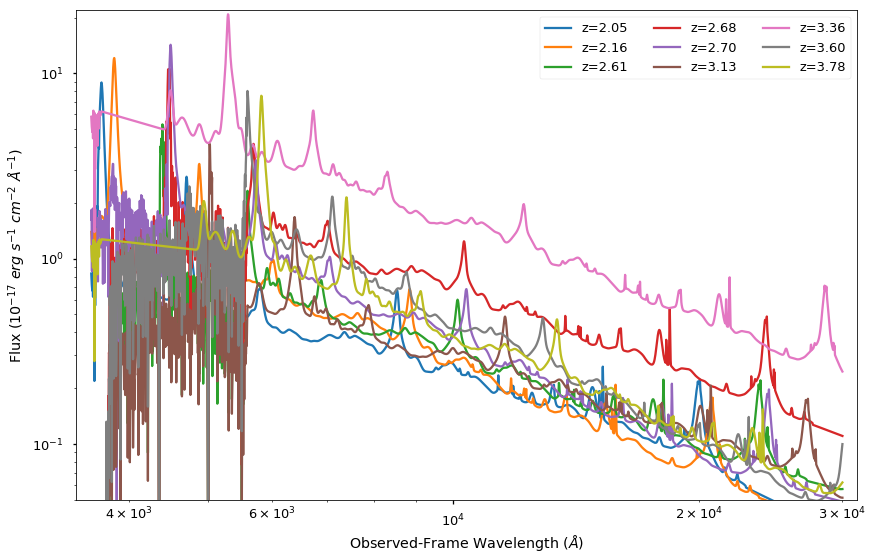

In [10]:
qaplot_handful()

#### Normalize and zoom into Lyman-alpha and the Lyman-alpha forest.

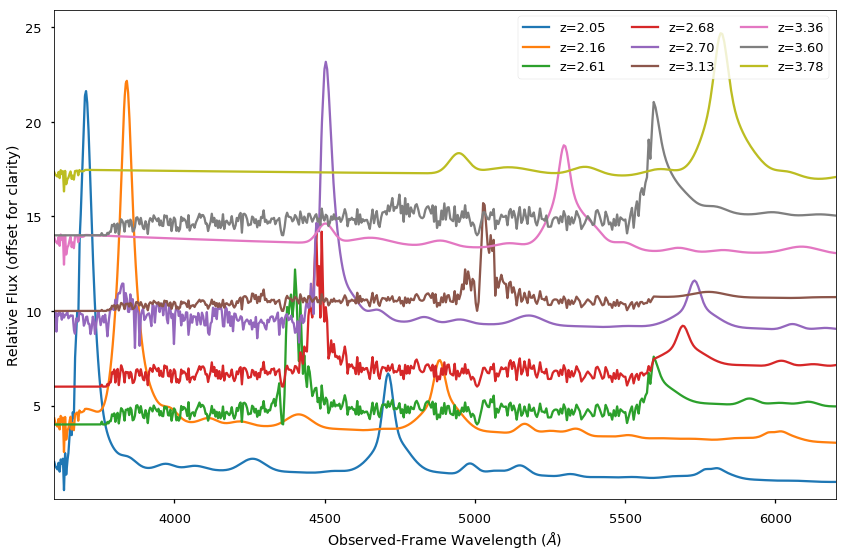

In [11]:
qaplot_handful((3600, 6200), norm=True, logwave=False)

### Make some templates using the PCA-based QSO() class and compare them.

In [12]:
qso = QSO(minwave=simqso.wave.min(), maxwave=simqso.wave.max())

In [13]:
zin, magin = meta['REDSHIFT'].data, meta['MAG'].data
%time qflux, qwave, qmeta = qso.make_templates(nmodel, seed=seed, redshift=zin, mag=magin, nocolorcuts=True)

CPU times: user 1.46 s, sys: 265 ms, total: 1.72 s
Wall time: 1.8 s


In [14]:
assert(np.all(qwave == wave))
assert(np.all(meta['REDSHIFT'].data == qmeta['REDSHIFT'].data))
assert(np.all(meta['MAG'].data == qmeta['MAG'].data))

In [15]:
def compare_templates(nplot=nmodel, ncol=3, xlim=None):
    """Plot a random sampling of the basis templates."""
    
    if xlim is None:
        xlim = (3600, 7000)
    
    nspec, npix = flux.shape
    nrow = np.ceil(nplot / ncol).astype('int')
    these = np.argsort(meta['REDSHIFT'].data)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4*ncol, 3*nrow), sharey=False, sharex=True)
    for ii, (thisax, indx) in enumerate(zip(ax.flat, these)):
        zz = meta['REDSHIFT'].data[indx]
        mm = meta['MAG'].data[indx]
        thisax.plot(wave, flux[indx, :], label='SIMQSO')
        thisax.plot(qwave, qflux[indx, :], alpha=0.7, label='QSO')
        thisax.set_xlim(xlim)
        ww = (wave > xlim[0]) * (wave < xlim[1])
        ylim = (flux[indx, ww].min(), flux[indx, ww].max())
        thisax.set_ylim((0.3, ylim[1]))
        thisax.set_xscale('log')
        thisax.set_yscale('log')
        thisax.yaxis.set_major_locator(plt.NullLocator())
        thisax.yaxis.set_minor_locator(plt.NullLocator())
        #if ii < nspec-ncol-1:
        thisax.xaxis.set_major_locator(plt.NullLocator())
        thisax.xaxis.set_minor_locator(plt.NullLocator())
        thisax.text(0.88, 0.88, 'z={:.2f}\nr={:.2f}'.format(zz, mm),
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=thisax.transAxes, fontsize=10)
        if ii == 0:
            thisax.legend(loc='upper left')

    #handles, labels = thisax.get_legend_handles_labels()
    #plt.figlegend(handles, labels, loc=(0.89, 0.88))
    fig.subplots_adjust(wspace=0.02, hspace=0.05)

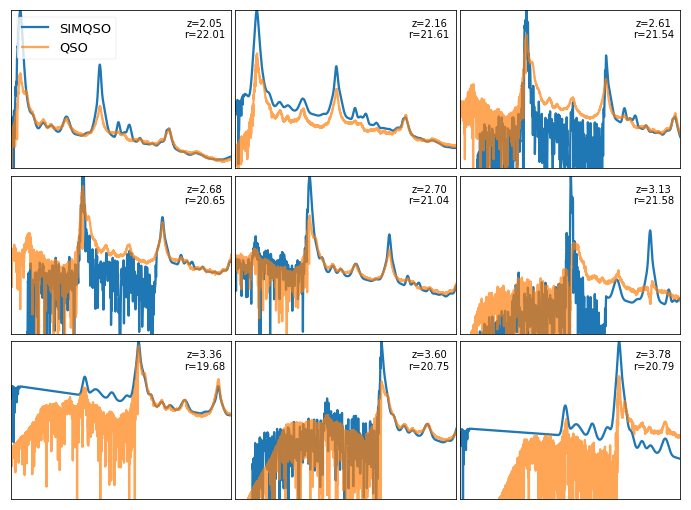

In [16]:
compare_templates()

### Now make more spectra with the redshift priors specified.

Turn off the Lyman-alpha forest for speed.

In [17]:
nmoremodel = 500
redshift = rand.uniform(2, 4, nmoremodel)

In [18]:
%time moreflux, morewave, moremeta, moreqsometa = simqso.make_templates(nmoremodel, seed=seed, redshift=redshift, \
                                                                        return_qsometa=True, lyaforest=False)

CPU times: user 30.1 s, sys: 1.77 s, total: 31.9 s
Wall time: 33.6 s


In [19]:
%time moreqflux, _, moreqmeta = qso.make_templates(nmoremodel, seed=seed, redshift=redshift, \
                                                   mag=moremeta['MAG'].data, lyaforest=False)

CPU times: user 1min 11s, sys: 11.1 s, total: 1min 22s
Wall time: 1min 25s


In [20]:
def qaplot_props():
    bins = nmoremodel//15
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
    _ = ax1.hist(moremeta['REDSHIFT'], bins=bins)
    ax1.set_xlabel('Redshift')
    ax1.set_ylabel('Number of Galaxies')
    
    _ = ax2.hist(moremeta['MAG'], bins=bins)
    ax2.set_xlabel(r'$r_{\rm DECaLS}$')
    
    _ = ax3.hist(moreqsometa['ABSMAG'], bins=bins)
    ax3.set_xlabel(r'$M_{1450}$')
    ax3.set_xlim(ax3.get_xlim()[::-1])
    plt.subplots_adjust(wspace=0.1)

#### Show the distribution of redshift, apparent magnitude, and absolute magnitude.

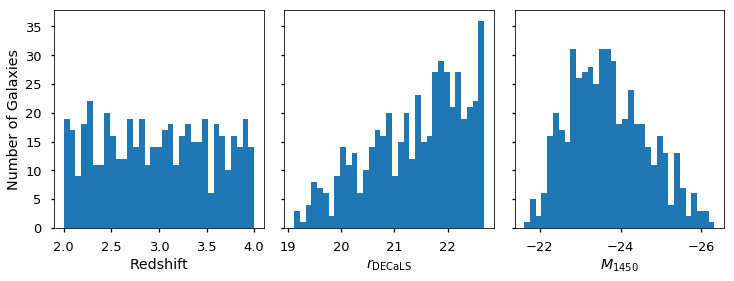

In [21]:
qaplot_props()

In [22]:
def qaplot_vsz():
    from matplotlib.ticker import MaxNLocator
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.scatter(moremeta['REDSHIFT'], moremeta['MAG'], edgecolor='k', alpha=0.9, s=50)
    ax1.set_xlabel('Redshift')
    ax1.set_ylabel(r'$r_{\rm DECaLS}$')
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax2.scatter(moremeta['REDSHIFT'], moreqsometa['ABSMAG'], edgecolor='k', alpha=0.9, s=50)
    ax2.set_ylabel(r'$M_{1450}$')
    ax2.set_xlabel('Redshift')
    ax2.set_ylim(ax2.get_ylim()[::-1])

    plt.subplots_adjust(wspace=0.3)

#### Show apparent and absolute magnitude vs redshift.

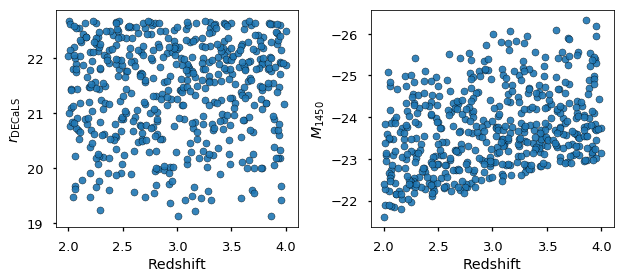

In [23]:
qaplot_vsz()

In [24]:
def flux2colors(cat):
    """Convert DECam/WISE fluxes to magnitudes and colors."""
    colors = dict()
    #with warnings.catch_warnings(): # ignore missing fluxes (e.g., for QSOs)
    #    warnings.simplefilter('ignore')
    colors['g'] = 22.5 - 2.5 * np.log10(cat['FLUX_G'])
    colors['r'] = 22.5 - 2.5 * np.log10(cat['FLUX_R'])
    colors['z'] = 22.5 - 2.5 * np.log10(cat['FLUX_Z'])
    colors['gr'] = colors['g'] - colors['r']
    colors['gz'] = colors['g'] - colors['z']
    colors['rz'] = colors['r'] - colors['z']
    colors['grz'] = 22.5-2.5*np.log10(cat['FLUX_G'] + 0.8 * cat['FLUX_R'] +  0.5 * cat['FLUX_G'] / 2.3)

    with np.errstate(invalid='ignore'):
        colors['W1'] = 22.5 - 2.5 * np.log10(cat['FLUX_W1'])
        colors['W2'] = 22.5 - 2.5 * np.log10(cat['FLUX_W2'])
        colors['W'] = 22.5 - 2.5 * np.log10(0.75 * cat['FLUX_W1'] + 0.25 * cat['FLUX_W2'])
        colors['rW'] = colors['r'] - colors['W']
        colors['W1W2'] = colors['W1'] - colors['W2']
        colors['grzW'] = colors['grz'] - colors['W']

    return colors

In [25]:
def qso_colorbox(ax, plottype='gr-rz', verts=None):
    """Draw the QSO selection boxes."""

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    if plottype == 'gr-rz':
        verts = [(-0.3, 1.3),
                 (1.1, 1.3),
                 (1.1, ylim[0]-0.05),
                 (-0.3, ylim[0]-0.05)
                ]
    
    if plottype == 'r-W1W2':
        verts = None
        ax.axvline(x=22.7, ls='--', lw=2, color='k')
        ax.axhline(y=-0.4, ls='--', lw=2, color='k')
    
    if plottype == 'gz-grzW':
        gzaxis = np.linspace(-0.5, 2.0, 50)
        ax.plot(gzaxis, np.polyval([1.0, -1.0], gzaxis), 
                 ls='--', lw=2, color='k')

    if verts:
        ax.add_patch(Polygon(verts, fill=False, ls='--', lw=2, color='k'))

In [26]:
def qaplot_colorcolor(old=False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
    ax1.scatter(colors['rz'], colors['gr'], edgecolor='k', 
                alpha=0.9, s=20, label='SIMQSO')
    if old:
        ax1.scatter(qcolors['rz'], qcolors['gr'], edgecolor='k', 
                    alpha=0.9, s=20, label='QSO')
    ax1.set_xlabel('$r - z$')
    ax1.set_ylabel('$g - r$')
    ax1.set_xlim(-0.5, 1.5)
    ax1.set_ylim(-1.0, 1.8)
    qso_colorbox(ax1, 'gr-rz')
    ax1.legend(loc='upper right', ncol=2)
    
    ax2.scatter(colors['r'], colors['W1W2'], edgecolor='k', alpha=0.9, s=20)
    ax2.set_xlabel('$r$')
    ax2.set_ylabel('$W_{1} - W_{2}$')
    ax2.set_xlim(18, 23.5)
    ax2.set_ylim(-0.5, 1)
    qso_colorbox(ax2, 'r-W1W2')
    
    ax3.scatter(colors['gz'], colors['grzW'], edgecolor='k', alpha=0.9, s=20)
    ax3.set_xlabel('$g - z$')
    ax3.set_ylabel('$grz - W$')
    ax3.set_xlim(-1, 1.5)
    ax3.set_ylim(-1, 1.5)
    qso_colorbox(ax3, 'gz-grzW')


    plt.subplots_adjust(wspace=0.35)

In [27]:
colors = flux2colors(moremeta)
qcolors = flux2colors(moreqmeta)

### Plot various color-color diagrams with the DESI/QSO selection boundaries overlaid.

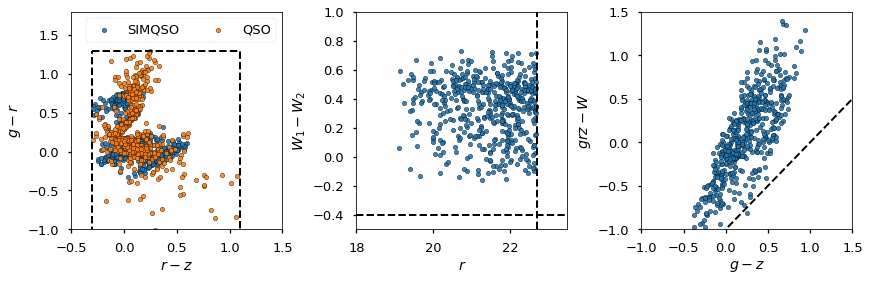

In [28]:
qaplot_colorcolor(old=True)